In [1]:
import numpy as np
import matplotlib.pyplot as plt
from seaborn import set_palette
flatui = ["#3498db", "#9b59b6", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
set_palette(flatui)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['grid.linewidth'] = 0.25
plt.rcParams['grid.alpha'] = 0.2
plt.style.use('seaborn-talk')

from IPython.display import Audio

In [2]:
# Microphone positions
pos_x = np.arange(-0.8, 0.8+1e-6, 0.2)
n_mics = len(pos_x)
pos_y = np.zeros(n_mics)
pos_z = np.zeros(n_mics)
mic_pos = np.row_stack((pos_x, pos_y, pos_z))

In [3]:
SOUND_SPEED = 340 # [m/s]
sampling_frequency = 44000 # [Hz]
frequency = 800 # [Hz]

In [4]:
# Source angles
theta_s = np.array([-10, 5, 30]) # [degree]
phi_s = np.array([0, 0, 0]) # [degree]

In [5]:
theta_grid = np.arange(-90, 90+1e-6, 0.1) # [degree]
phi_grid = np.array([0]) # [degree]

# Steering vectors
def steering_vectors(mic_pos, frequency, theta_grid, phi_grid):
    # wave number
    k = 2*np.pi*frequency/SOUND_SPEED

    n_mics = len(mic_pos[0])
    theta_grid = theta_grid * np.pi/180 # [degree] to [radian]
    phi_grid = phi_grid * np.pi/180 # [degree] to [radian]
    
    u = np.sin(theta_grid.reshape(-1, 1)).dot(np.cos(phi_grid).reshape(1, -1))
    v = np.sin(theta_grid.reshape(-1, 1)).dot(np.sin(phi_grid).reshape(1, -1))
    w = np.tile(np.cos(theta_grid.reshape(-1, 1)), (1, phi_grid.shape[0]))

    x = u.reshape(u.shape[0], u.shape[1], 1)*mic_pos[0].reshape(1, 1, n_mics)
    y = v.reshape(v.shape[0], v.shape[1], 1)*mic_pos[1].reshape(1, 1, n_mics)
    z = w.reshape(w.shape[0], w.shape[1], 1)*mic_pos[2].reshape(1, 1, n_mics)

    return np.exp( 1j*k*(x + y + z))

In [6]:
svs = steering_vectors(mic_pos, frequency=frequency, 
                       theta_grid=theta_grid, phi_grid=phi_grid)

In [7]:
# Delay-sum beamformer
source_steering_vector = steering_vectors(mic_pos, frequency, np.array([theta_s[0]]),
                           np.array([phi_s[0]]))
ds_beamformer = 1./n_mics * source_steering_vector

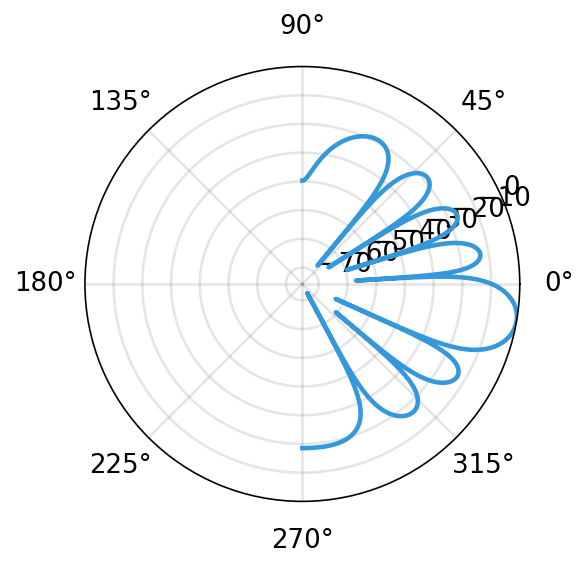

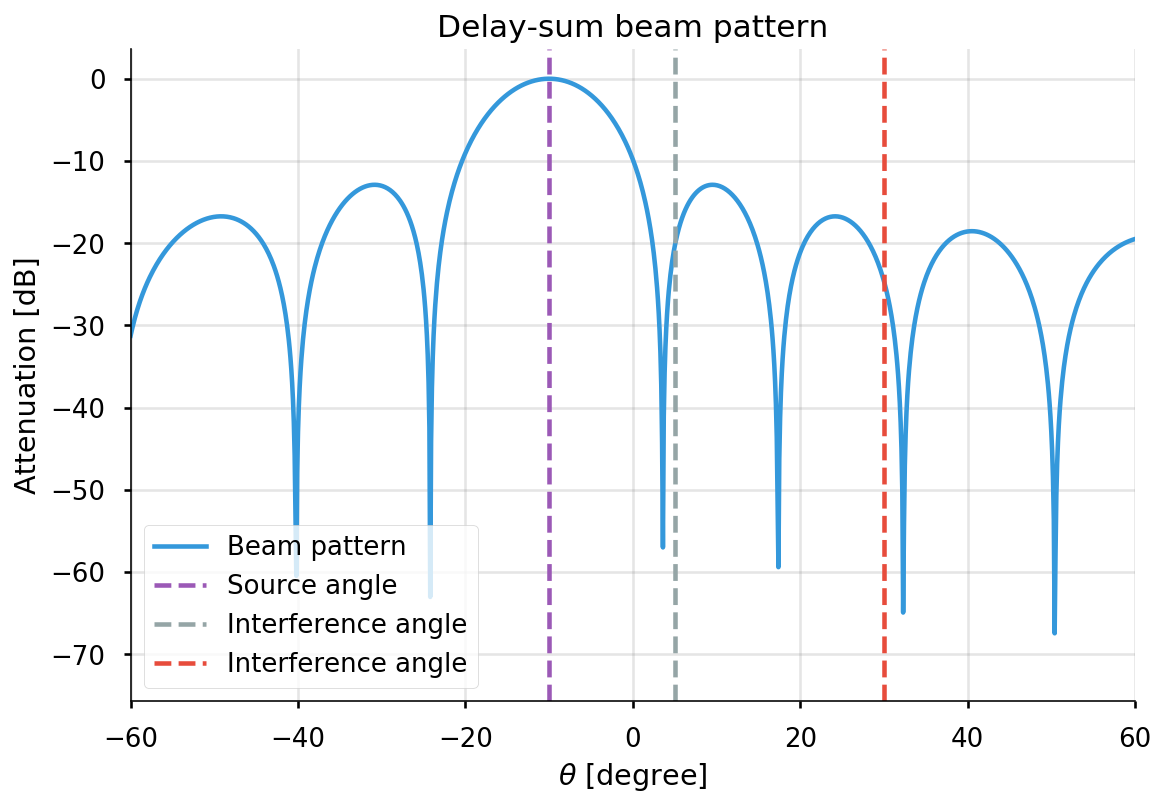

In [8]:
ds_beampattern = np.sum(ds_beamformer.conjugate() * svs, axis=2)
fig = plt.figure(); ax = fig.add_subplot(111, polar=True)
ax.plot(theta_grid*np.pi/180, 20*np.log10(np.abs(ds_beampattern[:, 0])));

fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(theta_grid, 20*np.log10(np.abs(ds_beampattern[:, 0])), label="Beam pattern");
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(1, len(theta_s)):
    ax.axvline(x=theta_s[i_interference], linestyle="--", color=flatui[i_interference+1], label="Interference angle");
ax.set_xlim(-60, 60);
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Attenuation [dB]");
ax.set_title("Delay-sum beam pattern");
ax.legend();

629.28534
889.80835
1090.2549


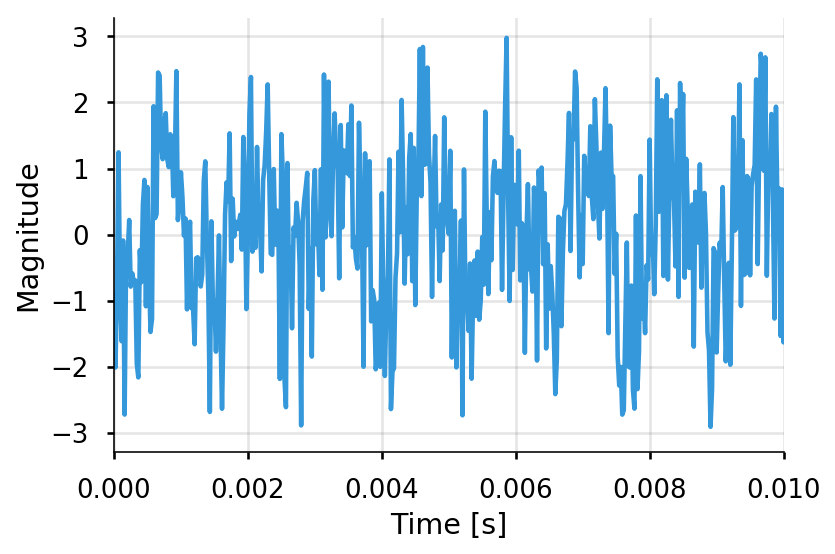

In [9]:
# Generate signal
duration = 44000/sampling_frequency # [s]
n_samples = int(np.floor(duration * sampling_frequency))
time_samples = np.arange(0, duration - 1/sampling_frequency, 1/sampling_frequency)
amplitudes = np.zeros(theta_s.shape)
signal = np.zeros((n_mics, n_samples), dtype=np.complex64)
interference = np.zeros((n_mics, n_samples), dtype=np.complex64)
np.random.seed(0)
for i_angle in range(len(theta_s)):
    doa = ( steering_vectors(mic_pos, frequency, np.array([theta_s[i_angle]]),
                           np.array([phi_s[i_angle]])) )[0, 0, :]
#     print(np.linalg.norm(doa))
    if i_angle == 0:
        signal += 10**(amplitudes[i_angle]/20)*doa.reshape([-1, 1])*\
                np.exp( 1j*2*np.pi*( frequency*time_samples.reshape([1, -1]) \
                        + 0*np.random.randn(1, n_samples)))
#         print(np.linalg.norm(signal))
    else:
        s = 10**(amplitudes[i_angle]/20)*doa.reshape([-1, 1])*\
                            np.exp( 1j*2*np.pi*( frequency*time_samples.reshape([1, -1]) \
                            + 1*np.random.randn(1, n_samples)))
        interference += s
    
        signal += s 
    print(np.linalg.norm(signal))
# Sample covariance matrix    
sample_covariance_matrix = 1./n_samples * ( signal.dot(signal.transpose().conjugate()) )
inverse_sample_covariance_matrix = np.linalg.inv(sample_covariance_matrix)
interference_R = 1./n_samples * (interference.dot(interference.transpose().conjugate()) + np.identity(n_mics))
interference_inverse_R = np.linalg.inv(interference_R)

fig = plt.figure(); ax = fig.add_subplot(111)
ax.plot(time_samples, signal[0].real);
ax.set_xlim([0, 0.01]); ax.set_xlabel("Time [s]"); ax.set_ylabel("Magnitude");

Audio(np.real(signal[0]), rate=sampling_frequency, autoplay=True)

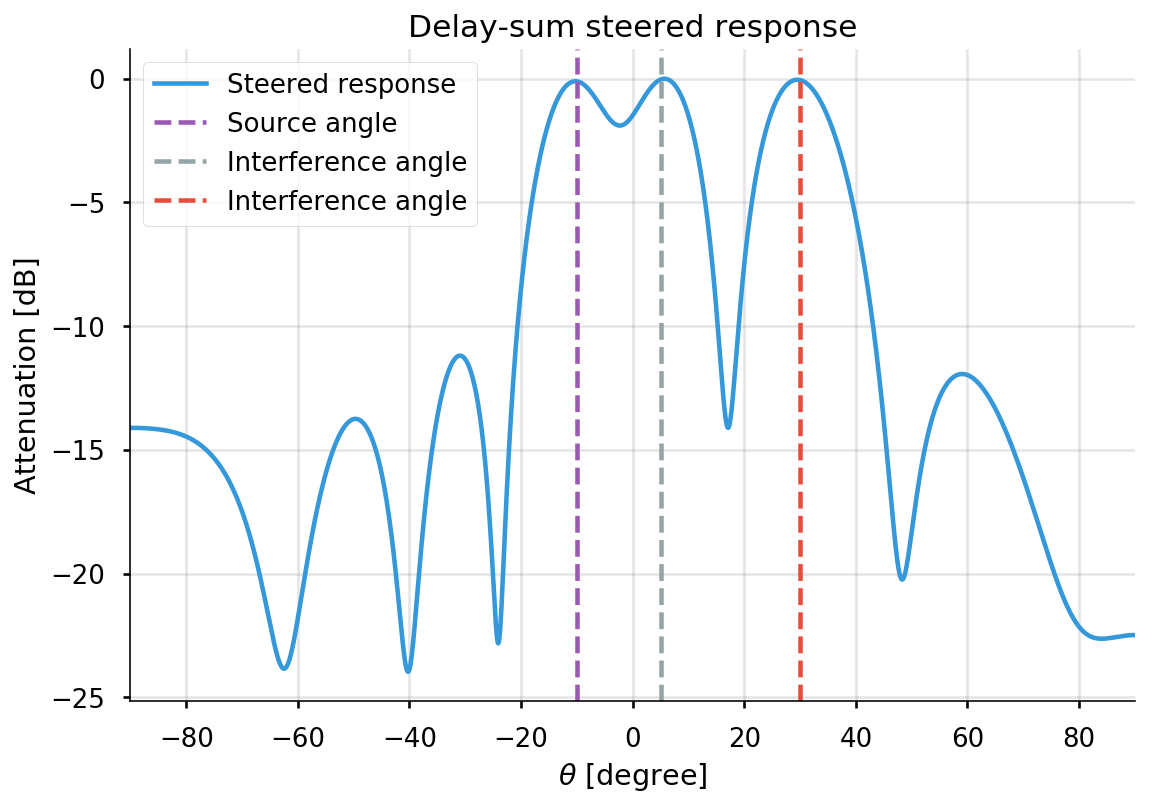

In [10]:
# Delay-sum steered response
ds_S = np.zeros((len(theta_grid), len(phi_grid)), dtype=np.complex64)
for i_theta in range(len(theta_grid)):
    for i_phi in range(len(phi_grid)):
        scanning_steering_vector = svs[i_theta][i_phi]
        ds_S[i_theta][i_phi] = (1./n_mics * scanning_steering_vector).transpose().conjugate().dot(
            sample_covariance_matrix).dot(1./n_mics * scanning_steering_vector)

ds_S_normalized = np.abs(ds_S)/np.max(np.abs(ds_S))
ds_S_db = 10*np.log10(ds_S_normalized);
fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(theta_grid, ds_S_db[:, 0], label="Steered response");
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(1, len(theta_s)):
    ax.axvline(x=theta_s[i_interference], linestyle="--", color=flatui[i_interference+1], label="Interference angle");
ax.set_xlim(-90, 90);
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Attenuation [dB]");
ax.set_title("Delay-sum steered response")
ax.legend();

In [11]:
np.linalg.norm(ds_S, ord='fro')
np.linalg.norm(svs[:, 0, :], ord='fro')
# np.linalg.norm(sample_covariance_matrix, ord='fro')
# np.linalg.norm(signal, ord='fro')

127.31457104353767

In [12]:
# MVDR beamformer
normalization_factor = source_steering_vector[0, 0, :].transpose().conjugate().dot(interference_inverse_R).dot(source_steering_vector[0, 0, :])
mvdr_beamformer = interference_inverse_R.dot(source_steering_vector[0, 0, :]) / normalization_factor

# MPDR beamformer
normalization_factor = source_steering_vector[0, 0, :].transpose().conjugate().dot(inverse_sample_covariance_matrix).dot(source_steering_vector[0, 0, :])
mpdr_beamformer = inverse_sample_covariance_matrix.dot(source_steering_vector[0, 0, :]) / normalization_factor

(1801, 1)

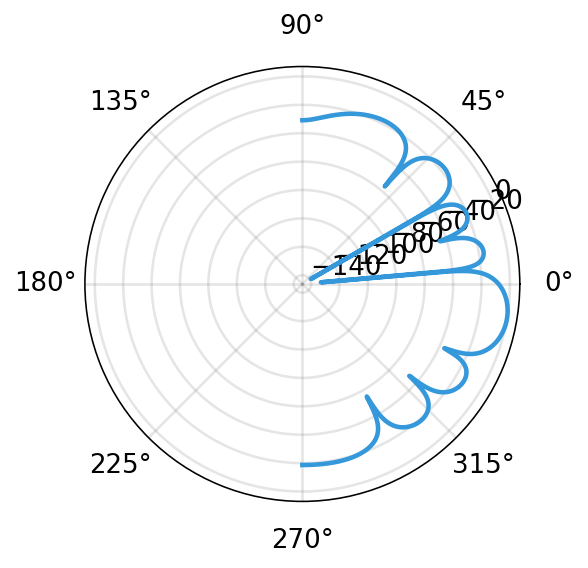

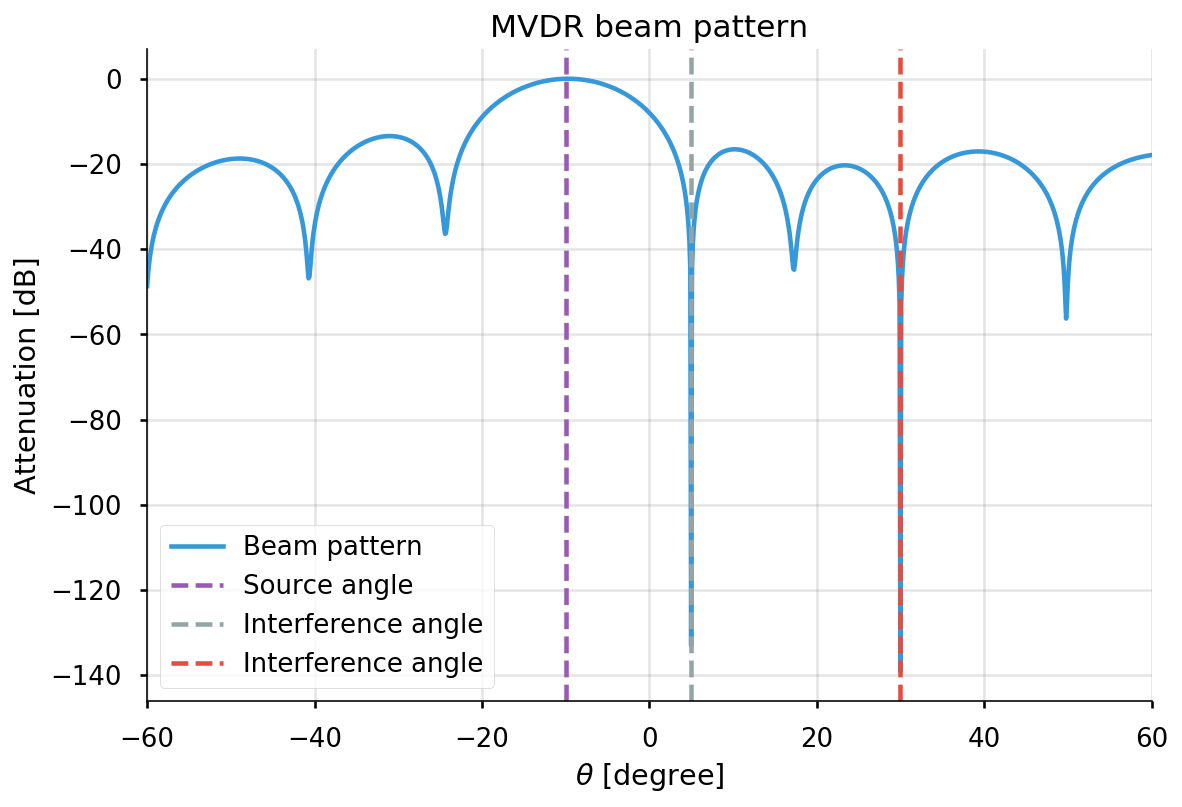

In [13]:
mvdr_beampattern = np.sum(mvdr_beamformer.reshape(1, 1, -1).conjugate() * svs, axis=2)
fig = plt.figure(); ax = fig.add_subplot(111, polar=True)
ax.plot(theta_grid*np.pi/180, 20*np.log10(np.abs(mvdr_beampattern[:, 0])));

fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(theta_grid, 20*np.log10(np.abs(mvdr_beampattern[:, 0])), label="Beam pattern");
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(1, len(theta_s)):
    ax.axvline(x=theta_s[i_interference], linestyle="--", color=flatui[i_interference+1], label="Interference angle");
ax.set_xlim(-60, 60);
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Attenuation [dB]");
ax.set_title("MVDR beam pattern");
ax.legend();
mvdr_beampattern.shape

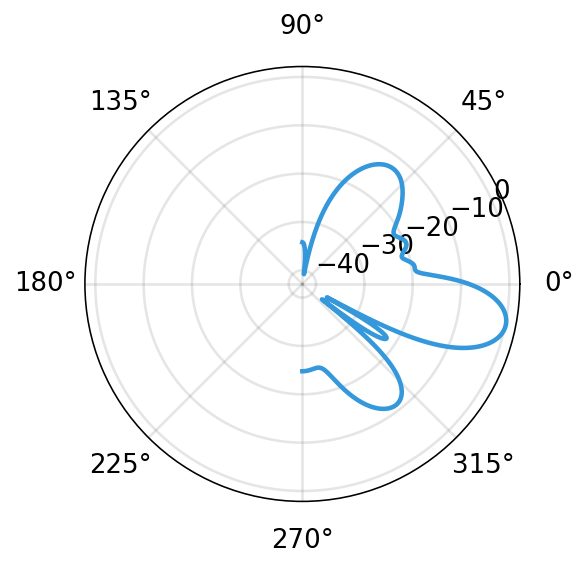

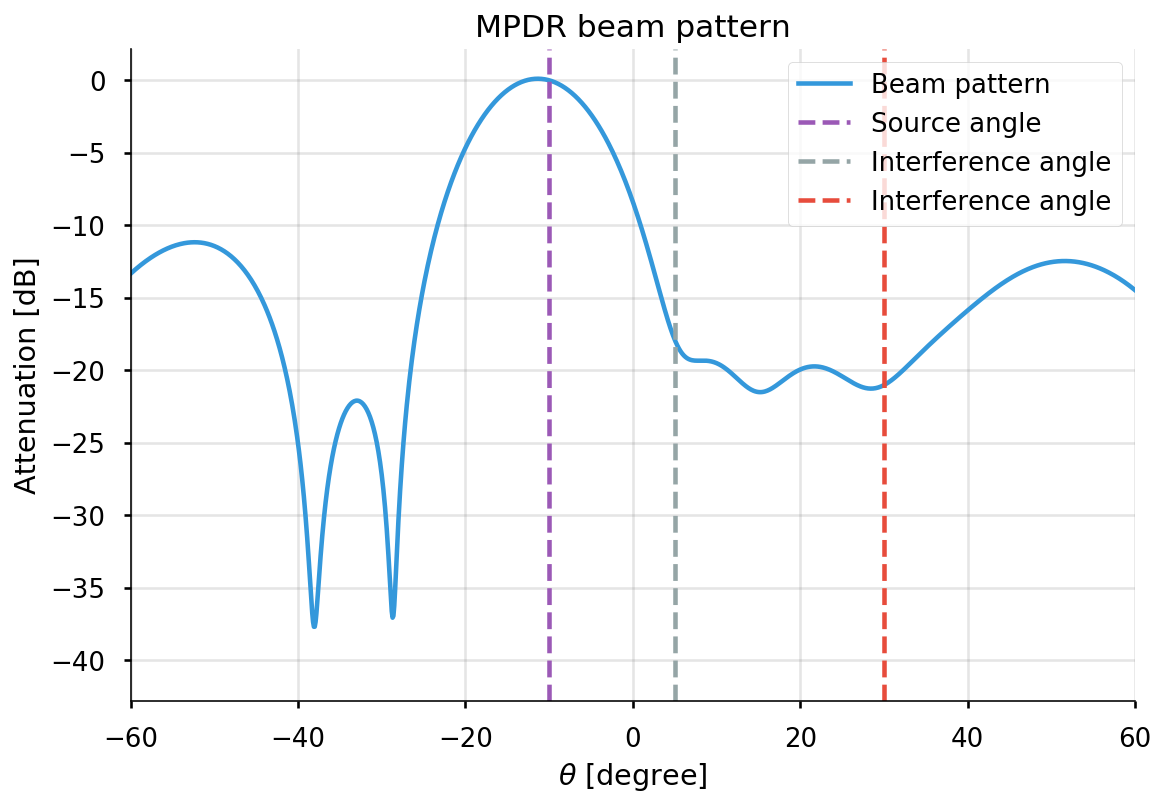

In [14]:
mpdr_beampattern = np.sum(mpdr_beamformer.reshape(1, 1, -1).conjugate() * svs, axis=2)
fig = plt.figure(); ax = fig.add_subplot(111, polar=True)
ax.plot(theta_grid*np.pi/180, 20*np.log10(np.abs(mpdr_beampattern[:, 0])));

fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(theta_grid, 20*np.log10(np.abs(mpdr_beampattern[:, 0])), label="Beam pattern");
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(1, len(theta_s)):
    ax.axvline(x=theta_s[i_interference], linestyle="--", color=flatui[i_interference+1], label="Interference angle");
ax.set_xlim(-60, 60);
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Attenuation [dB]");
ax.set_title("MPDR beam pattern");
ax.legend();

(1801, 1)

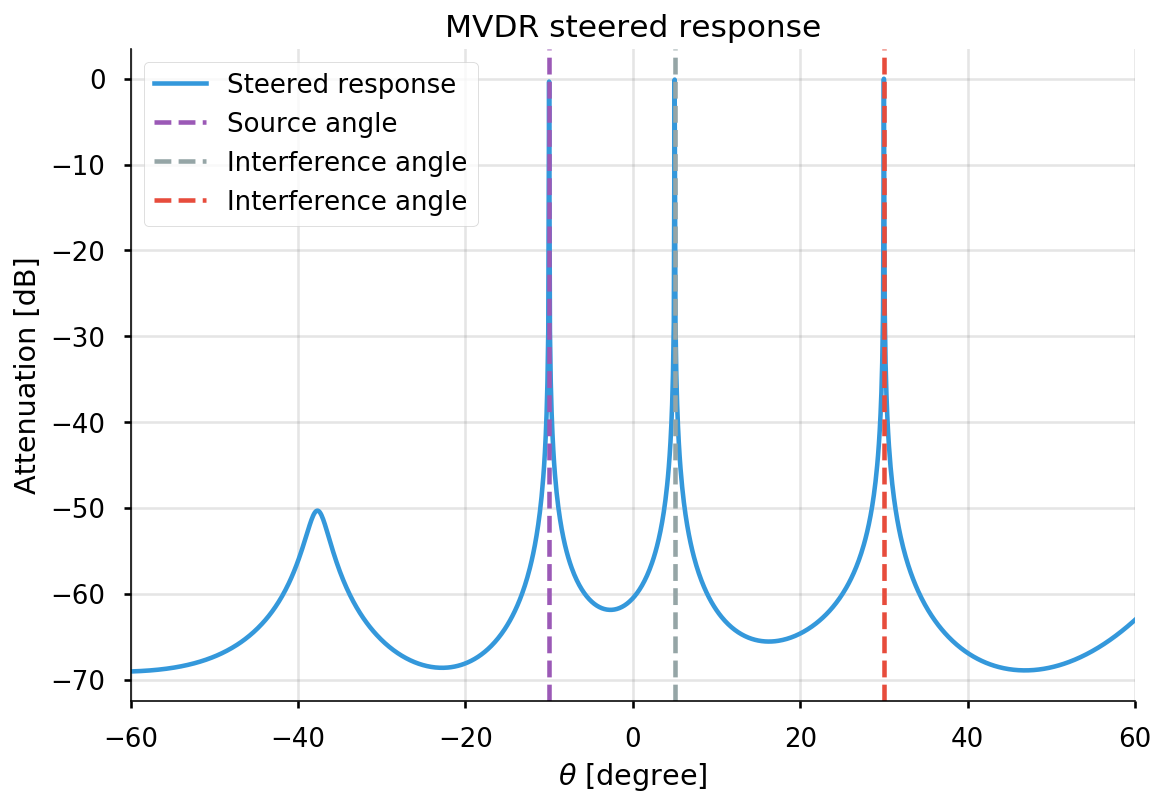

In [15]:
# Delay-sum steered response
mvdr_S = np.zeros((len(theta_grid), len(phi_grid)), dtype=np.complex64)
for i_theta in range(len(theta_grid)):
    for i_phi in range(len(phi_grid)):
        scanning_steering_vector = svs[i_theta][i_phi]
        mvdr_S[i_theta][i_phi] = 1. / ( scanning_steering_vector.transpose().conjugate().dot(inverse_sample_covariance_matrix).dot(scanning_steering_vector))

mvdr_S_normalized = np.abs(mvdr_S)/np.max(np.abs(mvdr_S))
mvdr_S_db = 10*np.log10(mvdr_S_normalized);
fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(theta_grid, mvdr_S_db[:, 0], label="Steered response");
ax.axvline(x=theta_s[0], linestyle="--", color=flatui[1], label="Source angle");
for i_interference in range(1, len(theta_s)):
    ax.axvline(x=theta_s[i_interference], linestyle="--", color=flatui[i_interference+1], label="Interference angle");
ax.set_xlim(-60, 60);
ax.set_xlabel(r"$\theta$ [degree]"); ax.set_ylabel("Attenuation [dB]");
ax.set_title("MVDR steered response")
ax.legend();
mvdr_S.shape

/anaconda3/envs/ml-p36/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


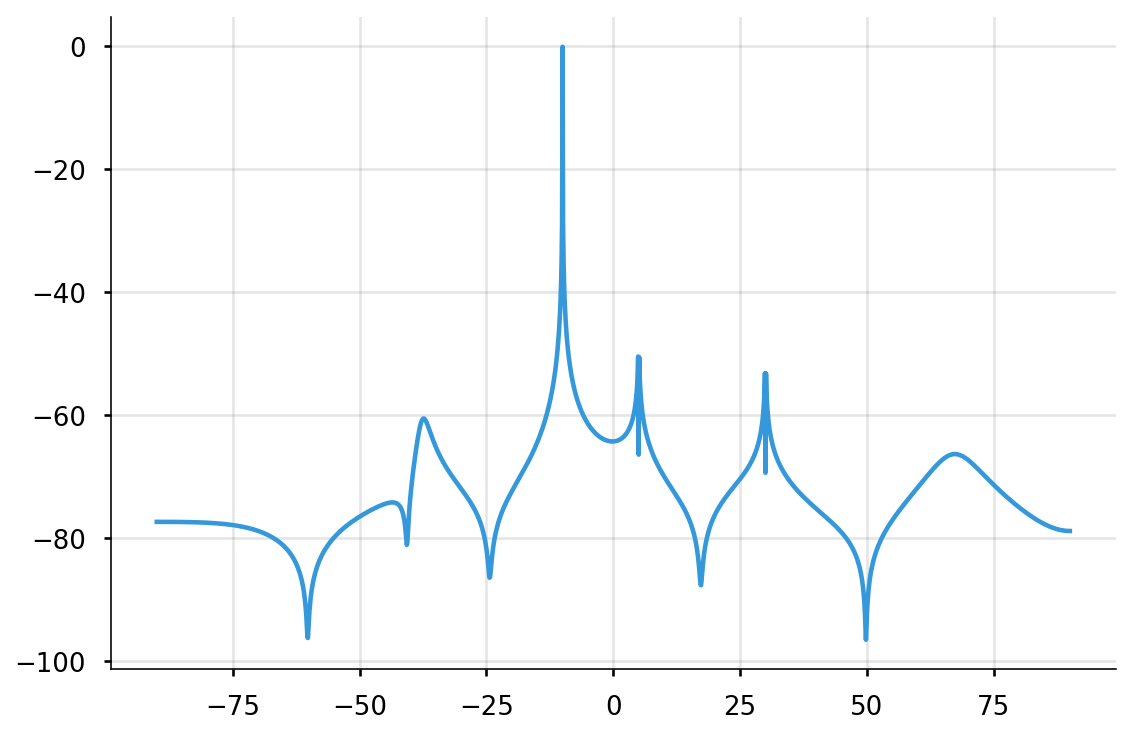

In [16]:
out = mvdr_beampattern * mvdr_S
out_db = 10*np.log10(out);
fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111)
ax.plot(theta_grid, out_db[:, 0], label="Steered response");

In [20]:
ds_out = ds_beamformer[0, 0, :].transpose().conjugate().dot(signal)
Audio(np.real(ds_out), rate=sampling_frequency, autoplay=True)

In [21]:
mpdr_out = mpdr_beamformer.transpose().conjugate().dot(signal)
Audio(np.real(mpdr_out), rate=sampling_frequency, autoplay=True)

In [22]:
mvdr_out = mvdr_beamformer.transpose().conjugate().dot(signal)
Audio(np.real(mvdr_out), rate=sampling_frequency, autoplay=True)